In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing CSRDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSRDataset instead.
  warn

In [ ]:
!pip install scanpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tempfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign

In [ ]:
train = sc.read_h5ad('/content/drive/MyDrive/train_set.h5ad')
test = sc.read_h5ad('/content/drive/MyDrive/test_set.h5ad')

In [ ]:
sc.pp.highly_variable_genes(
    train,
    flavor="seurat_v3",
    n_top_genes=2000,
    subset=True
)

In [ ]:
common_genes = train.var_names.intersection(test.var_names)

In [ ]:
train = train[:, common_genes]
test = test[:, common_genes]

In [ ]:
train.obs

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes
cell,,,,,,
C18.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,5071
P6.MAA000926.3_9_M.1.1,endothelial cell,Cortex,M,3_9_M,MAA000926,2506
F21.MAA000561.3_10_M.1.1,endothelial cell,Cortex,M,3_10_M,MAA000561,4605
A3.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2216
I12.MAA000581.3_10_M.1.1,brain pericyte,Cerebellum,M,3_10_M,MAA000581,3752
...,...,...,...,...,...,...
E6.MAA000935.3_8_M.1.1,oligodendrocyte,Hippocampus,M,3_8_M,MAA000935,5182
K4.MAA000563.3_10_M.1.1,oligodendrocyte precursor cell,Hippocampus,M,3_10_M,MAA000563,3790
K2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2107


In [ ]:
train.obs['labels'] = train.obs['cell_ontology_class'].astype(str)  #
train.obs['dataset'] = 'train'

#test
test.obs['labels'] = 'Unknown'  #mark test data as unlabeled
test.obs['dataset'] = 'test'

#
test.obs['true_labels'] = test.obs['cell_ontology_class'].astype(str)

<ipython-input-10-7a043452d5ad>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  train.obs['labels'] = train.obs['cell_ontology_class'].astype(str)  #
<ipython-input-10-7a043452d5ad>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test.obs['labels'] = 'Unknown'  #mark test data as unlabeled


In [ ]:
#@title  AnnData object for scANVI
scvi.model.SCANVI.setup_anndata(
    train,
    unlabeled_category = 'unkonwn',
    labels_key='cell_ontology_class'    #types
)


In [ ]:
model = scvi.model.SCANVI(
    train # Ignored here since all cells in train are labeled
)
model.train()

INFO     Training for 400 epochs.                                                                                  


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [ ]:
test.obs['predicted_labels'] = model.predict(test)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
from sklearn.metrics import classification_report

#true and predicted labels
true_labels = test.obs['cell_ontology_class']  #
predicted_labels = test.obs['predicted_labels']

df = pd.DataFrame({'True': true_labels, 'Predicted': predicted_labels})
df.to_csv('SCVI.csv', index=False)

In [ ]:
df

,True,Predicted
cell,,
B18.MAA000942.3_8_M.1.1,oligodendrocyte,oligodendrocyte
C2.MAA000932.3_11_M.1.1,brain pericyte,brain pericyte
F7.MAA000638.3_9_M.1.1,endothelial cell,endothelial cell
A9.MAA001845.3_39_F.1.1,endothelial cell,endothelial cell
C1.MAA000578.3_10_M.1.1,Bergmann glial cell,Bergmann glial cell
...,...,...
P21.MAA000926.3_9_M.1.1,endothelial cell,endothelial cell
E19.MAA000538.3_8_M.1.1,Bergmann glial cell,Bergmann glial cell
A13.MAA000560.3_10_M.1.1,astrocyte,astrocyte


In [ ]:
from sklearn.metrics import classification_report,hamming_loss

#true and predicted labels
true_labels = test.obs['cell_ontology_class']  #
predicted_labels = test.obs['predicted_labels']

#######
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Classification Report:
                                precision    recall  f1-score   support

           Bergmann glial cell       1.00      0.75      0.86         8
                     astrocyte       0.97      0.97      0.97        87
                brain pericyte       0.94      1.00      0.97        31
              endothelial cell       1.00      0.99      0.99       143
                        neuron       0.96      0.96      0.96        56
               oligodendrocyte       0.99      0.98      0.99       315
oligodendrocyte precursor cell       0.93      1.00      0.96        41

                      accuracy                           0.98       681
                     macro avg       0.97      0.95      0.96       681
                  weighted avg       0.98      0.98      0.98       681



In [ ]:
predicted_labels

,predicted_labels
cell,
B18.MAA000942.3_8_M.1.1,oligodendrocyte
C2.MAA000932.3_11_M.1.1,brain pericyte
F7.MAA000638.3_9_M.1.1,endothelial cell
A9.MAA001845.3_39_F.1.1,endothelial cell
C1.MAA000578.3_10_M.1.1,Bergmann glial cell
...,...
P21.MAA000926.3_9_M.1.1,endothelial cell
E19.MAA000538.3_8_M.1.1,Bergmann glial cell
A13.MAA000560.3_10_M.1.1,astrocyte


Accuracy: 0.98
F1 Score (Weighted): 0.98


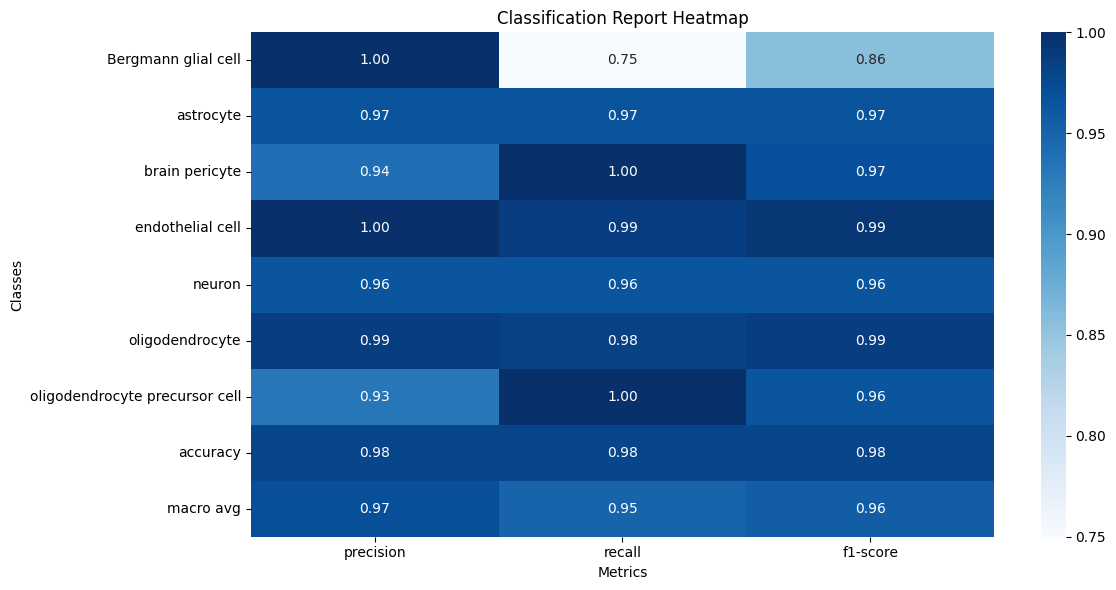

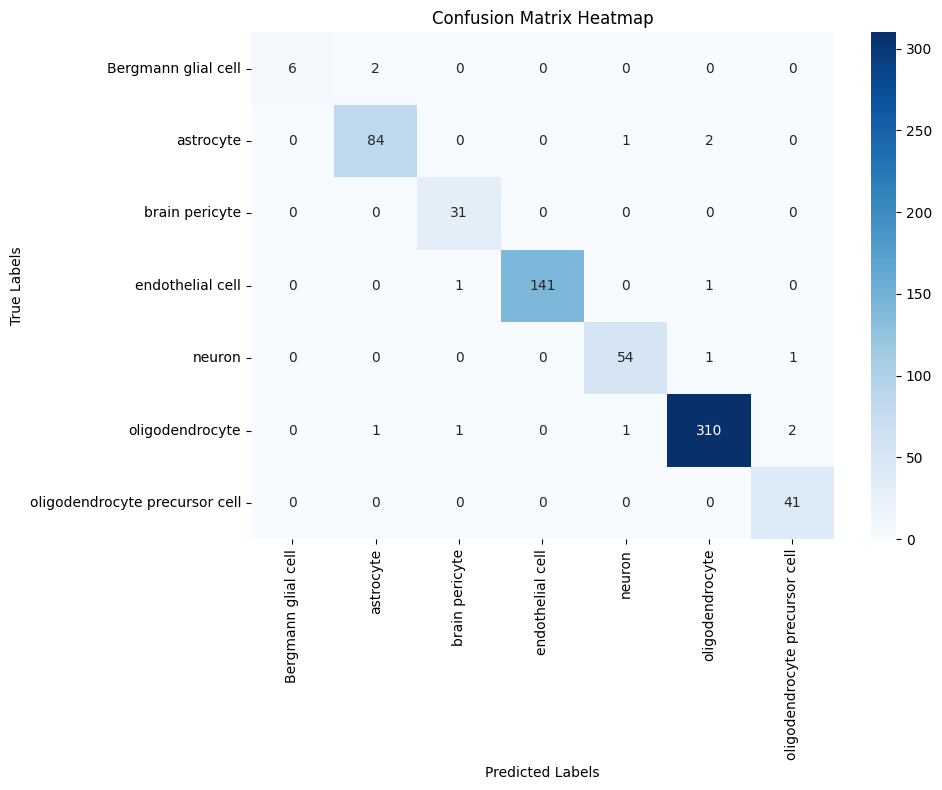

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score


true_labels = test.obs['cell_ontology_class']  # Ground truth
true_labels_list = true_labels.tolist()
predicted_labels_list = predicted_labels.tolist()

#############
report = classification_report(true_labels_list, predicted_labels_list, output_dict=True)
report_df = pd.DataFrame(report).transpose()
conf_matrix = confusion_matrix(true_labels_list, predicted_labels_list)
unique_labels = sorted(set(true_labels_list))

# accuracy and F1
accuracy = accuracy_score(true_labels_list, predicted_labels_list)
f1 = f1_score(true_labels_list, predicted_labels_list, average='weighted')

##########
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score (Weighted): {f1:.2f}")
plt.figure(figsize=(12, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [ ]:
true_counts = pd.Series(true_labels_list).value_counts(normalize=True).sort_index()
predicted_counts = pd.Series(predicted_labels_list).value_counts(normalize=True).sort_index()
proportion_df = pd.DataFrame({
    'Cell Type': true_counts.index.union(predicted_counts.index),
    'Real': true_counts.reindex(true_counts.index.union(predicted_counts.index), fill_value=0),
    'Predicted': predicted_counts.reindex(true_counts.index.union(predicted_counts.index), fill_value=0)
}).melt(id_vars=['Cell Type'], var_name='Type', value_name='Proportion')

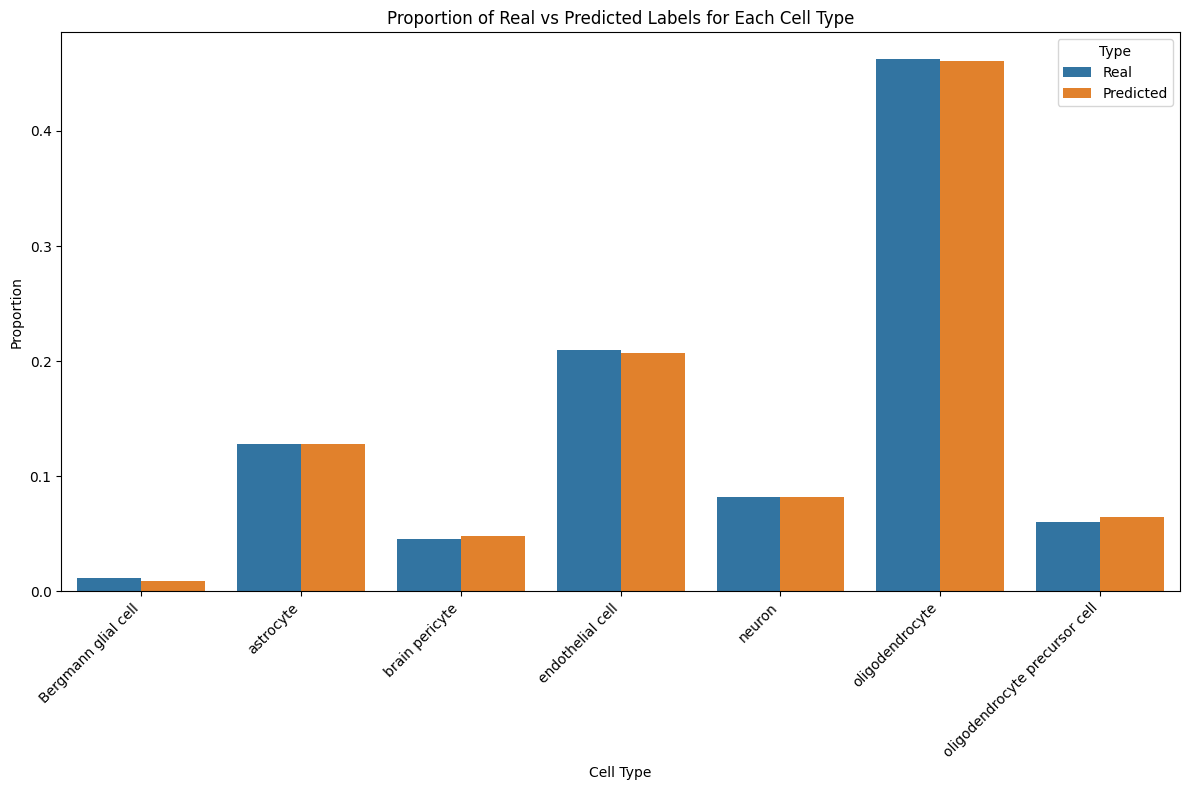

In [ ]:



plt.figure(figsize=(12, 8))
sns.barplot(data=proportion_df, x='Cell Type', y='Proportion', hue='Type', errorbar=None)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title("Proportion of Real vs Predicted Labels for Each Cell Type")
plt.xlabel("Cell Type")
plt.ylabel("Proportion")
plt.legend(title="Type", loc='upper right')
plt.tight_layout()
plt.show()
